In [2]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic.infection import Infection
from laser_generic.susceptibility import Susceptibility
from laser_generic.transmission import Transmission
from laser_generic.utils import seed_infections_randomly
from laser_generic.utils import set_initial_susceptibility_randomly

f"{np.__version__=}"

"np.__version__='1.26.4'"

In [2]:
scenario = pd.DataFrame(data=[["homenode", 1e6, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "beta": 0.1, "inf_mean": 50})

2024-12-11 04:05:59.186137: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-11 04:05:59.350363: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:13<00:00, 55.32it/s] 


Completed the generic model at 2024-12-11 04:06:12.553374…
Model         :         9,315 µs
Susceptibility:     1,110,329 µs
Transmission  :     8,151,573 µs
Infection     :     3,472,809 µs
Total:             12,744,026 microseconds


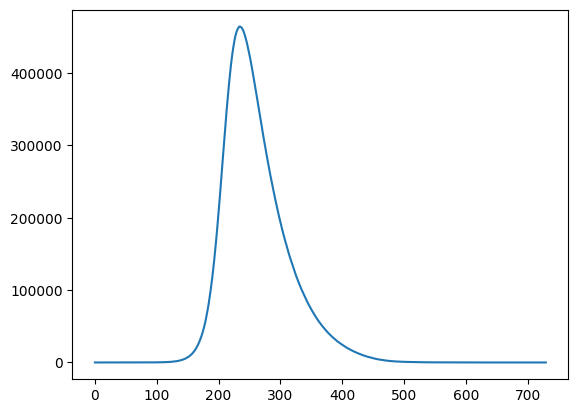

In [3]:
model = Model(scenario, parameters)
model.components = [
    Susceptibility,
    Transmission,
    Infection,
]

set_initial_susceptibility_randomly(model, 1.0)
seed_infections_randomly(model, ninfections=1)
model.run()
plt.plot(model.patches.cases)

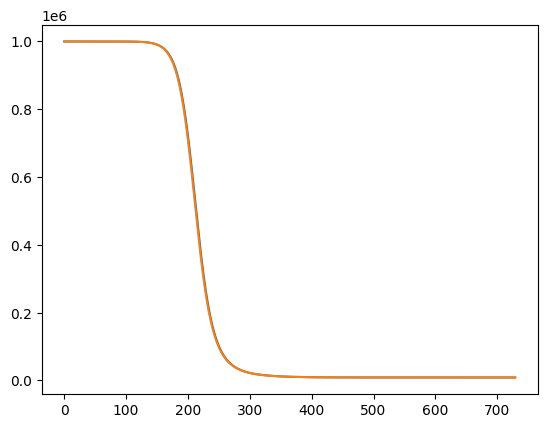

In [4]:
plt.plot(model.patches.susceptibility)
plt.plot(1e6 - np.cumsum(model.patches.incidence))

In [5]:
def KM_limit(z, R0, S0, I0):
    if R0 * S0 < 1:
        return 0
    else:
        return z - S0 * (1 - np.exp(-R0 * (z + I0)))


population = 1e5
# fsolve(KM_limit, 0, args=(3.0, 0.2, 0.0001))
R0s = np.concatenate((np.linspace(0.2, 1.0, 5), np.linspace(1.5, 10.0, 25)))
S0s = [1.0, 0.8, 0.6, 0.4, 0.2]
output = pd.DataFrame(list(itertools.product(R0s, S0s)), columns=["R0", "S0"])
output["I_inf_exp"] = [
    fsolve(KM_limit, 0.5 * (R0 * S0 >= 1), args=(R0, S0, 20 / population))[0] for R0, S0 in zip(output["R0"], output["S0"])
]
output["S_inf_exp"] = output["S0"] - output["I_inf_exp"]
output["I_inf_obs"] = np.nan
output["S_inf_obs"] = np.nan

In [6]:
%%capture

inf_mean = 20
for index, row in output.iterrows():
    scenario = pd.DataFrame(data=[["homenode", population, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
    parameters = PropertySet({"seed": 2, "nticks": 730, "verbose": True, "inf_mean": inf_mean, "beta": row["R0"] / inf_mean})

    model = Model(scenario, parameters)
    model.components = [
        Susceptibility,
        Transmission,
        Infection,
    ]

    set_initial_susceptibility_randomly(model, row["S0"])
    seed_infections_randomly(model, ninfections=20)
    model.run()

    output.loc[index, "I_inf_obs"] = np.sum(model.patches.incidence) / population
    output.loc[index, "S_inf_obs"] = model.patches.susceptibility[-1] / population


# for R0 in R0s:
#     for S0 in S0s:
#         expected =

In [7]:
output

,R0,S0,I_inf_exp,S_inf_exp,I_inf_obs,S_inf_obs
0,0.2,1.0,0.000000,1.000000,0.00002,0.99978
1,0.2,0.8,0.000000,0.800000,0.00001,0.79980
2,0.2,0.6,0.000000,0.600000,0.00001,0.59979
3,0.2,0.4,0.000000,0.400000,0.00000,0.39980
4,0.2,0.2,0.000000,0.200000,0.00000,0.19980
...,...,...,...,...,...,...
145,10.0,1.0,0.999955,0.000045,0.99972,0.00008
146,10.0,0.8,0.799731,0.000269,0.79940,0.00041
147,10.0,0.6,0.598493,0.001507,0.59782,0.00198
148,10.0,0.4,0.392086,0.007914,0.39072,0.00908


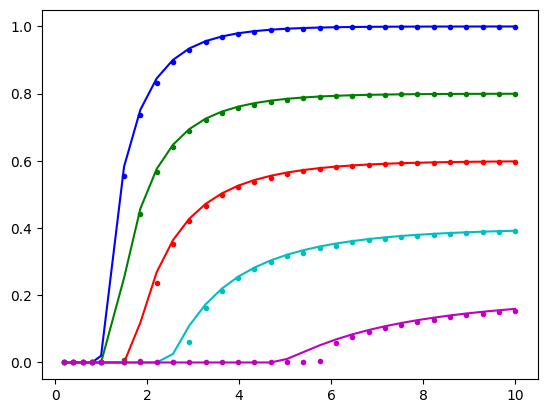

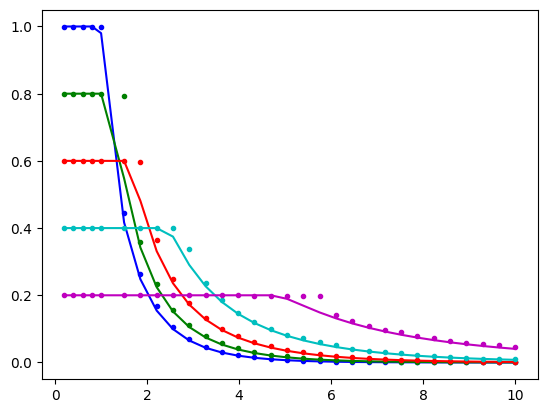

In [15]:
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_exp"], label=f"Expected S0={S0}", color=color)
    plt.plot(output[condition]["R0"], output[condition]["I_inf_obs"], ".", label=f"Observed S0={S0}", color=color)
plt.figure()
colors = itertools.cycle(["b", "g", "r", "c", "m", "y", "k"])
for S0 in S0s:
    condition = output["S0"] == S0
    color = next(colors)

    plt.plot(output[condition]["R0"], output[condition]["S_inf_exp"], label=f"Expected S0={S0}", color=color)
    plt.plot(output[condition]["R0"], output[condition]["S_inf_obs"], ".", label=f"Observed S0={S0}", color=color)
# condition = output['S0'] == 1.0
# plt.plot(output[condition]['R0'], output[condition]['I_inf_exp'], label='Expected')
# plt.plot(output[condition]['R0'], output[condition]['I_inf_obs'], '.', label='Observed')

In [6]:
np.random.exponential(1 / (50 / 365 / 1000), 10)

array([16281.11655109,  3584.21707715,  7170.77377301,  5566.01033623,
        3106.52167692,  6429.95493347,  3483.72935794,   308.61376256,
       18790.33897488, 12446.34708649])